In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

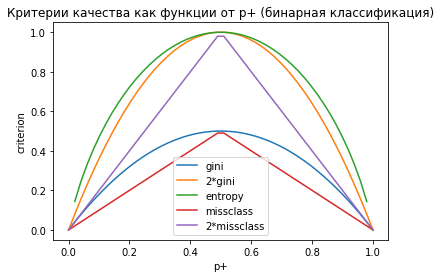

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend();

### Пример

 Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [3]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно, прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то гладкая граница, разделяющая 2 класса, или хотя бы просто прямая (в n-мерном случае – гиперплоскость).

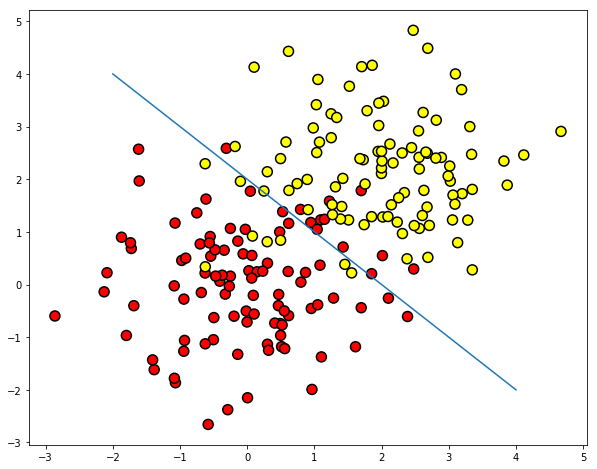

In [4]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр max_depth, ограничивающий глубину дерева. Визуализируем полученную границу разделения классов.

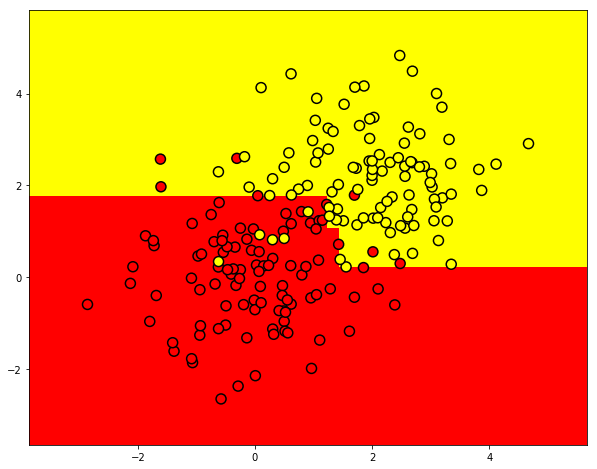

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [9]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
out_file='../img/small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng '../img/small_tree.dot' -o '../img/small_tree.png'

FileNotFoundError: [Errno 2] No such file or directory: '../img/small_tree.dot'

# Примеры применения

### Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они.

In [10]:
df = pd.read_csv('../data/telecom_churn.csv')

df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели. Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
random_state=17)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов. Сделаем прогнозы для отложенной выборки. Дерево решений справилось лучше: доля правильных ответов около 94% против 88% у kNN. Но это мы пока выбирали параметры наугад.

In [12]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred) # 0.94

0.93999999999999995

In [13]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred) # 0.88

0.88100000000000001

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений параметров max_depth и max_features будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

In [14]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [15]:
tree_params = {'max_depth': range(1,11),
'max_features': range(4,19)}

In [16]:
tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

In [17]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   18.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [18]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [19]:
tree_grid.best_score_

0.94256322331761677

In [20]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.94599999999999995

Теперь попробуем настроить число соседей в алгоритме kNN.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [23]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [24]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [25]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [26]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.88598371195885128)

In [27]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89000000000000001

В этом примере дерево показало себя лучше, чем метод ближайших соседей: 94.2% правильных ответов на кросс-валидации и 94.6% на отложенной выборке против 88.6% / 89% для kNN. Более того, в данной задаче дерево проявляет себя очень хорошо, и даже случайный лес (который пока представляем просто как кучу деревьев, которые вместе работают почему-то намного лучше, чем одно дерево) в этом примере показывает долю правильных ответов не намного выше (95.1% на кросс-валидации и 95.3% –на отложенной выборке), а обучается намного дольше.

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5))) # 0.949

0.949423311981


In [29]:
forest_params = {'max_depth': range(1,11),
'max_features': range(4,19)}

In [30]:
forest_grid = GridSearchCV(forest, forest_params,
cv=5, n_jobs=-1,
verbose=True)

In [31]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [32]:
forest_grid.best_params_, forest_grid.best_score_ # ({'max_depth': 9, 'max_features': 6}, 0.951)

({'max_depth': 9, 'max_features': 6}, 0.95113587655379339)

In [33]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout)) # 0.953

0.95299999999999996

Нарисуем получившееся дерево. Из-за того, что оно не совсем игрушечное (максимальная глубина – 6), картинка получается уже не маленькой, но по дереву можно "прогуляться", если отдельно открыть рисунок.

In [35]:
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
out_file='../img/churn_tree.dot', filled=True)
!dot -Tpng '../img/churn_tree.dot' -o '../../img/churn_tree.png'

FileNotFoundError: [Errno 2] No such file or directory: '../img/churn_tree.dot'